# Spectral Fitting

This notebook measures aperiodic activity using various different spectral fitting measures.

There have been many variations for fitting power spectra. This notebook compares different strategies.

This notebooks covers:
- Linear fits to power spectra in log-log spacing, using a simple (OLS) linear fit
- Linear fits to power spectra in log-log spacing, using a robust (RLM) linear fit
- Linear fits to power spectra in log-log spacing, using the RANSAC robust fitting algorithm
- Exponential fits to power spectra in semi-log spacing, using a simple exponential fit
- The [spectral parameterization](https://fooof-tools.github.io/) method

In addition, various studies have used simple heuristics to try and fit aperiodic activity while avoiding being biased by peaks. 

In this comparison, we include the following variations of the aforementioned methods:
- Fitting the entire frequency range 
- Using a predefined exclusion zone of the alpha oscillation (7-14 Hz)
- Using exclusing zones for all oscillatory peaks*

*Note that in the oscillation exclusion approach, the spectral parameterization method is initially used to detect and exclude oscillatory regions. Therefore, these are not fully independent methods, but are instead used to evaluate if there could be any improved fitting after oscillation exclusion. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.linear_model import RANSACRegressor

from fooof import FOOOF
from fooof.plts.spectra import plot_spectra, plot_spectra_shading
from fooof.core.funcs import expo_nk_function as expf
from fooof.sim import gen_power_spectrum, gen_group_power_spectra
from neurodsp.utils import set_random_seed

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_16023/655100508.py:9: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, save_pickle, load_pickle
from apm.methods import SpectralFits
from apm.sim.peaks import gen_peak_def
from apm.plts.errors import plot_violin_errors, plot_boxplot_errors
from apm.plts.results import plot_corr_matrix
from apm.plts.utils import make_axes, figsaver, color_red_or_green
from apm.plts.settings import FIT_COLOR, SP_COLOR
from apm.utils.data import exclude_spectrum
from apm.utils import print_results

In [3]:
# Set plot style
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Simulation settings
f_range = [1, 50]
off_val = 0
noise = 0.0

In [5]:
# Define method colors
palette = {
    'OLS' : FIT_COLOR,
    'RLM' : FIT_COLOR,
    'RAN' : FIT_COLOR,
    'EXP' : FIT_COLOR,
    'SP' : SP_COLOR,
}

In [6]:
# PSD plot settings
PSD_PLT_KWARGS = {
    'figsize' : (6, 5),
    'log_powers' : True,
    'grid' : False,
    'colors' : ['black', 'blue'],
}

BOXPLOT_SETTINGS = {
    'ylabel' : 'Error',
    'width' : 0.7,
    'palette' : palette,
    'saturation' : 0.75,
}

In [7]:
# Run Settings
SAVE_DATA = False
RERUN = False            # If False, reloads previously computed measures

In [8]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '31_fitting'

# Create helper function to manage figsaver settings
fsaver = figsaver(SAVE_FIG, FIGPATH)

In [9]:
# Settings for loading simulations
SIMPATH = APMDB().sims_path / 'psds'

In [10]:
# Set the random seed
set_random_seed(111)

## Spectral Fitting Methods

Here we demonstrate spectral fitting methods for measuring the aperiodic exponent by directly fitting power spectra.

The implementations of these methods are available in `apm/fit.py`.

### Example PSD

Load an example PSD, from eyes closed, resting state EEG data, extracted to the range of 3-40 Hz. 

In [11]:
# Load an example power spectrum to check fitting with
freqs = np.load('data/freqs.npy')
psd = np.load('data/psd.npy')

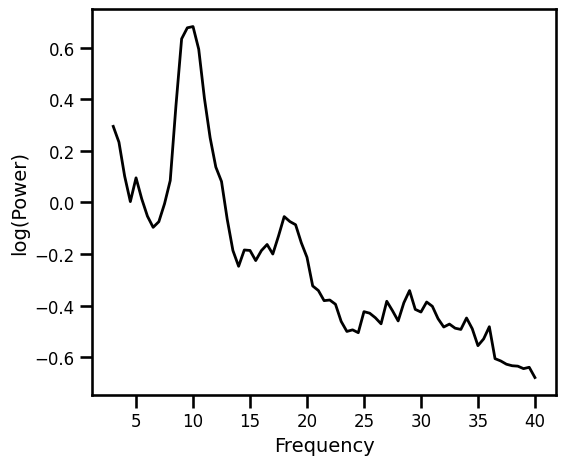

In [12]:
# Check a plot of the loaded power spectrum
plot_spectra(freqs, psd, **PSD_PLT_KWARGS, **fsaver('power_spectrum'))

## Methods for Fitting Power Spectra

Here, we introduce the various methods for fitting the aperiodic component of the power spectrum. 

In [13]:
# Initialize for collecting example fit results
example_results = {}

In [14]:
# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs))

### OLS Linear Fit

Fit a line in log-log with Ordinary Least Squares (OLS).

In [15]:
# Spectral fit: linear fit
ex_fit_ols = sm.OLS(np.log10(psd), fx).fit()
example_results['ols'] = ex_fit_ols.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols.fittedvalues)

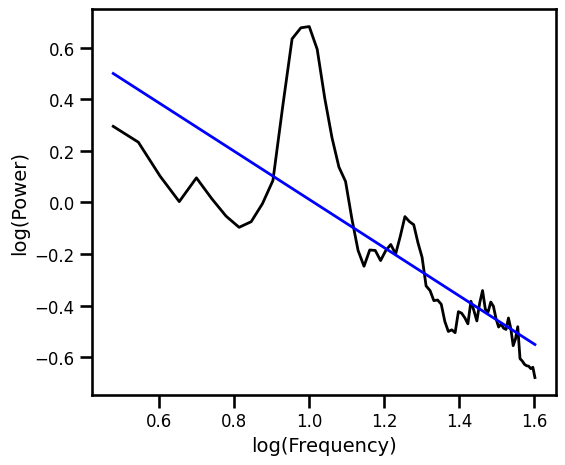

In [16]:
# Plot the aperiodic fit, from the OLS linear fit
plot_spectra(freqs, [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_ols'))

### Robust Fit with RLM

In [17]:
# Spectral fit: robust linear fit to log-log PSD
ex_fit_rlm = sm.RLM(np.log10(psd), fx).fit()
example_results['rlm'] = ex_fit_rlm.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm.fittedvalues)

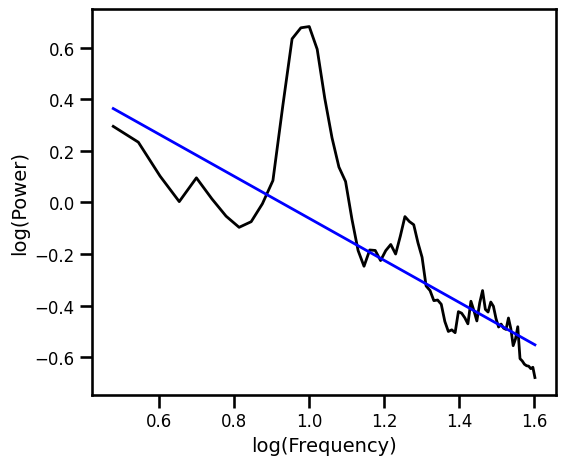

In [18]:
# Plot the aperiodic fit, from the robust linear fit
plot_spectra(freqs, [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_rlm'))

### Robust Fit with RANSAC

In [19]:
# Reshape freqs for RANSAC fit
freqs_ran = freqs.reshape([len(freqs), 1])

In [20]:
# Initialize and fit with RANSAC
ex_ransac_model = RANSACRegressor()
ex_ransac_model.fit(np.log10(freqs_ran), np.log10(psd))
example_results['ran'] = ex_ransac_model.estimator_.coef_[0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model.predict(np.log10(freqs_ran)))

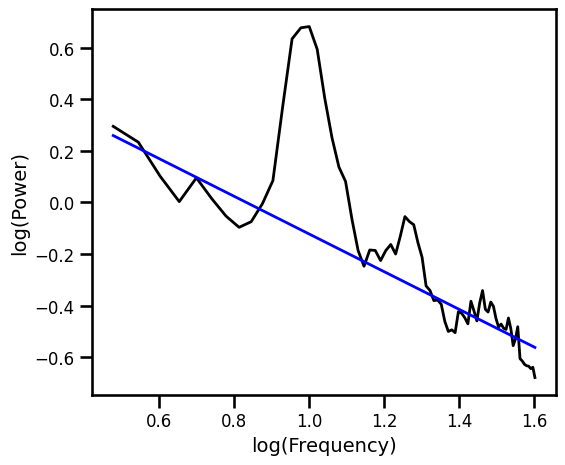

In [21]:
# Plot the aperiodic fit, from RANSAC
plot_spectra(freqs_ran.flatten(), [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_ransac'))

## Spectral Fitting Excluding Alpha

Use a specific exclusion zone for the alpha oscillation.

In [22]:
# Exclude predefined alpha range
freqs_alph, psd_alph = exclude_spectrum(np.squeeze(freqs), psd, [7, 14], False)

# Reset freqs, with constant
fx_alph = sm.add_constant(np.log10(freqs_alph))

### Simple OLS Linear Fit Exlucing Generic Alpha Band

In [23]:
# Linear fit without alpha range
ex_fit_ols_alph = sm.OLS(np.log10(psd_alph), fx_alph).fit()
example_results['ols_alph'] = ex_fit_ols_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols_alph.fittedvalues)

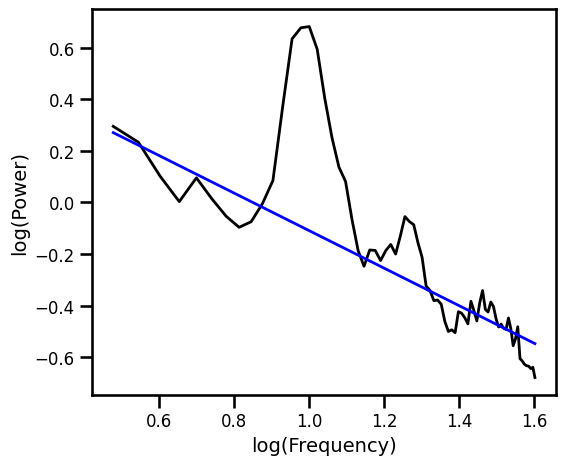

In [24]:
# Plot the aperiodic fit, from an OLS linear fit with an alpha exclusion zone
plot_spectra([freqs, freqs_alph], [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_ols_alph'))

### Robust Fit with RLM Excluding Generic Alpha Band

In [25]:
# Robust fit without alpha range
ex_fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx_alph).fit()
example_results['rlm_alph'] = ex_fit_rlm_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm_alph.fittedvalues)

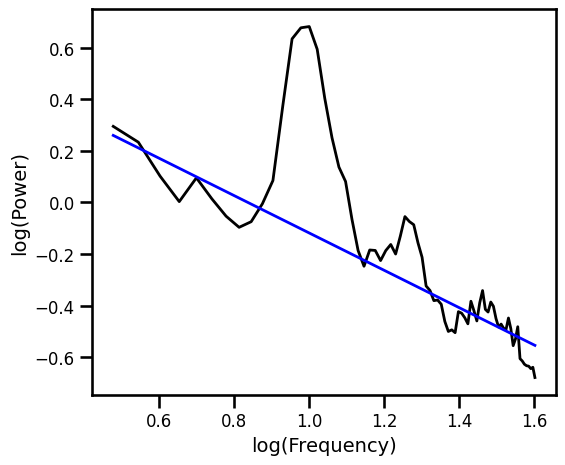

In [26]:
# Plot the aperiodic fit, from the robust linear fit with an alpha exclusion zone
plot_spectra([freqs, freqs_alph], [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_rlm_alph'))

### Robust Fit with RANSAC Excluding Generic Alpha Band

In [27]:
# Fit alpha-exclusion with RANSAC
ex_ransac_model_alph = RANSACRegressor()
ex_ransac_model_alph.fit(np.log10(freqs_alph).reshape(-1, 1), np.log10(psd_alph).reshape(-1, 1))
example_results['ran_alph'] = ex_ransac_model_alph.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model_alph.predict(np.log10(freqs_alph).reshape(-1, 1)))

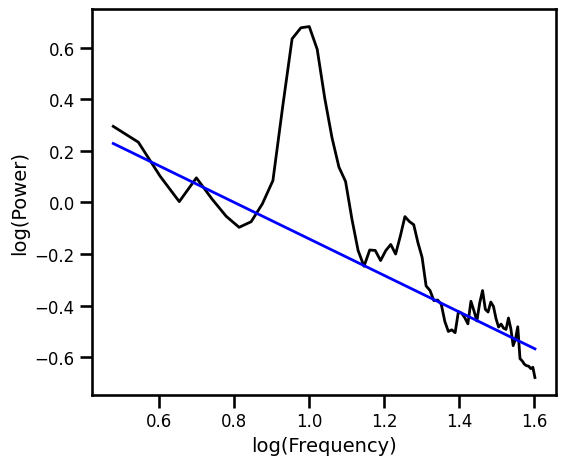

In [28]:
# Plot the aperiodic fit, from the RANSAC fit with alpha exclusion zone
plot_spectra([freqs, freqs_alph], [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_ransac_alph'))

## Spectral Fit Excluding Oscillations

Use a exclusion zones for oscillations.

In [29]:
# Fit spectral model for finding peaks
fm = FOOOF(peak_width_limits=[1, 8])
fm.fit(freqs, psd, [3, 40])

In [30]:
# Get oscillation definitions from FOOOF
cens = fm.gaussian_params_[:, 0]
bws = fm.gaussian_params_[:, 2]

# Define oscillation ranges, as a range around each center frequency
m = 2
osc_ranges = [[cen-m*bw, cen+m*bw] for cen, bw in zip(cens, bws)]

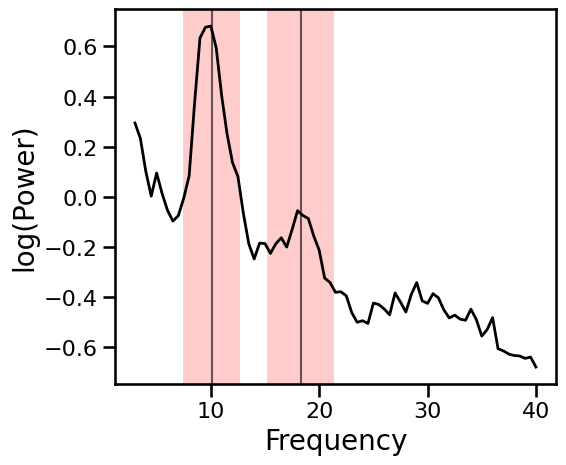

In [31]:
# Plot PSD with oscillatory regions shaded
plot_spectra_shading(freqs, psd, osc_ranges, add_center=True,
                     **PSD_PLT_KWARGS, **fsaver('data_peaks'))

In [32]:
# Exclude oscillation bands, as measured from FOOOF
psd_excl = psd
freqs_excl = np.squeeze(freqs)

for cen, bw in zip(cens, bws):
    freqs_excl, psd_excl = exclude_spectrum(freqs_excl, psd_excl, [cen-m*bw, cen+m*bw])

In [33]:
# Create a frequency vector with exlcusion zones for model fitting
fx_excl = sm.add_constant(np.log10(freqs_excl))

### Simple Linear Fit Excluding Oscillatory Bands

In [34]:
# Linear fit without alpha range
ex_fit_ols_excl = sm.OLS(np.log10(psd_excl), fx_excl).fit()
example_results['ols_excl'] = ex_fit_ols_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols_excl.fittedvalues)

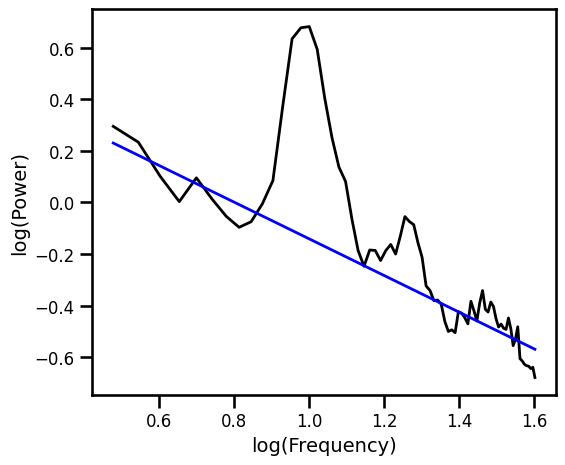

In [35]:
# Plot the aperiodic fit, from the OLS linear fit with oscillation exclusion zones
plot_spectra([freqs, freqs_excl], [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_ols_osc'))

### Robust Fit with RLM Excluding Oscillatory Bands

In [36]:
# Robust fit without oscillation bands
ex_fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx_excl).fit()
example_results['rlm_excl'] = ex_fit_rlm_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm_excl.fittedvalues)

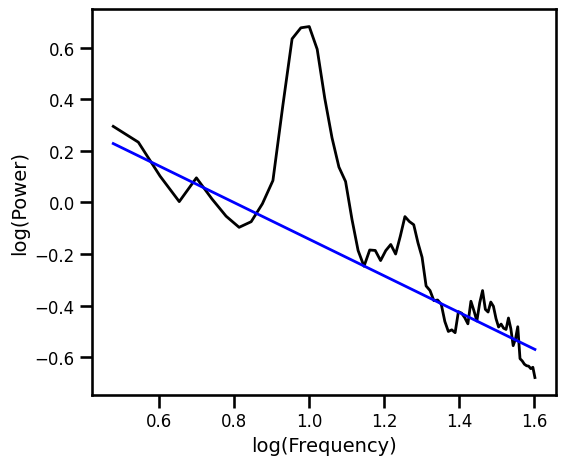

In [37]:
# Plot the aperiodic fit, from the robust linear fit with oscillation exclusion zones
plot_spectra([freqs, freqs_excl], [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_rlm_osc'))

### Robust Fit with RANSAC Excluding Oscillatory Bands

In [38]:
# Fit alpha-exclusion with RANSAC
ex_ransac_model_excl = RANSACRegressor()
ex_ransac_model_excl.fit(np.log10(freqs_excl), np.log10(psd_excl))
example_results['ran_excl'] = ex_ransac_model_excl.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model_excl.predict(np.log10(freqs_excl)))

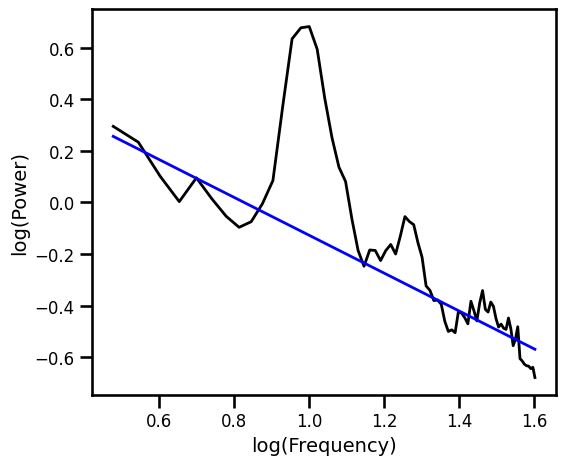

In [39]:
# Plot the aperiodic fit, from the RANSAC fit with oscillation exclusion zones
plot_spectra([freqs, freqs_excl], [psd, pred_vals], log_freqs=True, 
             **PSD_PLT_KWARGS, **fsaver('fit_ransac_osc'))

## Exponential Fits

### Exponential Fit

In [40]:
# Fit exponential 1/f, with scipy curve_fit
ex_fit_exp, _ = curve_fit(expf, np.squeeze(freqs), np.squeeze(np.log10(psd)), p0=[1, 1])
example_results['exp'] = -ex_fit_exp[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs, *ex_fit_exp))

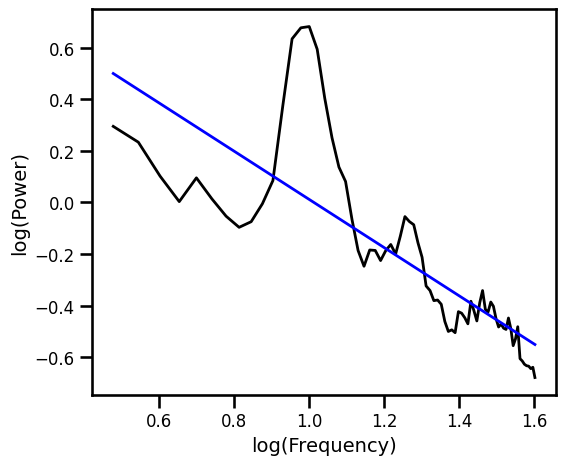

In [41]:
# Plot the aperiodic fit, from the exponential fit
plot_spectra(freqs.flatten(), [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_exp'))

### Exponential Fit Excluding Alpha Region

In [42]:
# Fit exponential 1/f, with scipy curve_fit, excluding alpha range
ex_fit_exp_alph, _ = curve_fit(expf, np.squeeze(freqs_alph),
                               np.squeeze(np.log10(psd_alph)), p0=[1, 1])
example_results['exp_alph'] = -ex_fit_exp_alph[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_alph, *ex_fit_exp_alph))

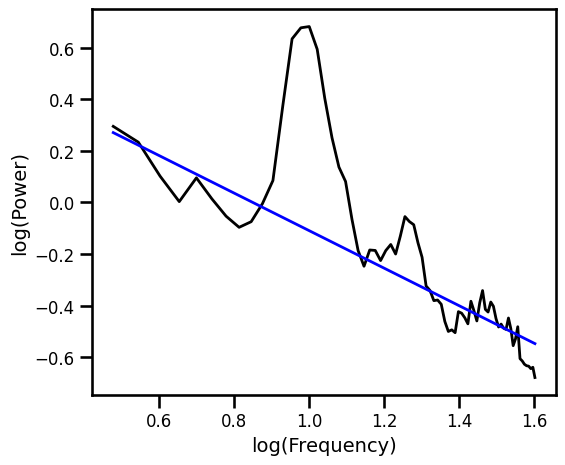

In [43]:
# Plot the aperiodic fit, from the exponential fit, with an alpha exclusion zone
plot_spectra([freqs, freqs_alph], [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_exp_alph'))

### Exponential Fit Excluding Oscillation Regions

In [44]:
# Fit exponential 1/f, with scipy curve_fit, excluding oscillatory regions
ex_fit_exp_excl, _ = curve_fit(expf, np.squeeze(freqs_excl),
                               np.squeeze(np.log10(psd_excl)), p0=[1, 1])
example_results['exp_excl'] = -ex_fit_exp_excl[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_excl, *ex_fit_exp_excl))

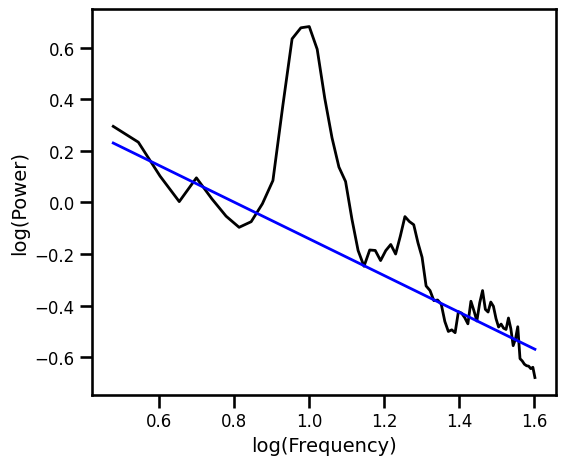

In [45]:
# Plot the aperiodic fit, from the exponential fit with oscillation exclusion zones
plot_spectra([freqs, freqs_excl], [psd, pred_vals], log_freqs=True,
             **PSD_PLT_KWARGS, **fsaver('fit_exp_osc'))

## Spectral Parameterization

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.5498, 0.6997                                          
                                                                                                  
                                       2 peaks were found:                                        
          

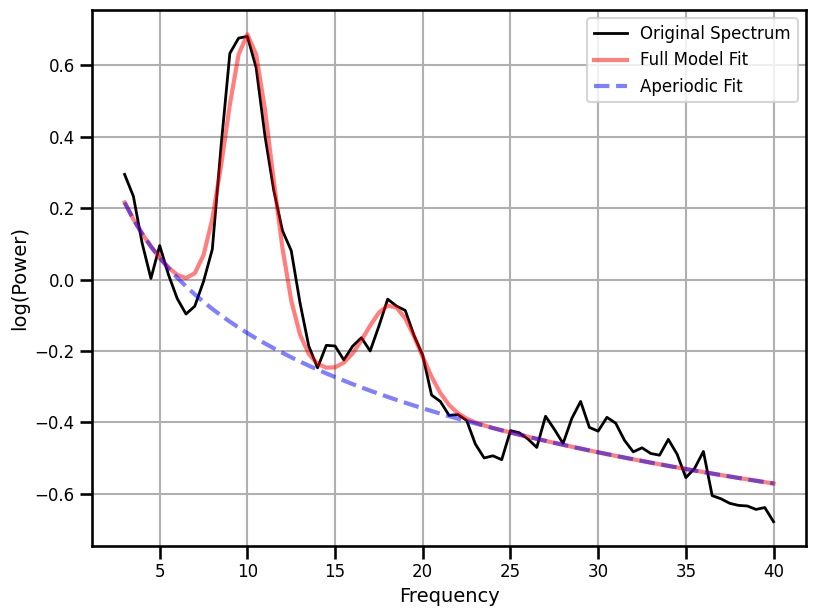

In [46]:
# Fit the SpecParam model
fm = FOOOF(verbose=False)
fm.report(freqs, psd, [3, 40])
example_results['fooof'] = -fm.aperiodic_params_[1]

## Compare Example Fits

In [47]:
# Print out results across all the different approaches
print('FIT RESULTS')
for key, val in example_results.items():
    print('  {:10s} \t {:1.3f}'.format(key, val))

FIT RESULTS
  ols        	 -0.933
  rlm        	 -0.813
  ran        	 -0.729
  ols_alph   	 -0.726
  rlm_alph   	 -0.723
  ran_alph   	 -0.707
  ols_excl   	 -0.710
  rlm_excl   	 -0.709
  ran_excl   	 -0.733
  exp        	 -0.933
  exp_alph   	 -0.726
  exp_excl   	 -0.710
  fooof      	 -0.700


In [48]:
# Check fits ordered by magnitude
for key, val  in dict(sorted(example_results.items(), key=lambda it: it[1])).items():
    print('{:10s} \t {:1.5f}'.format(key, val))

ols        	 -0.93306
exp        	 -0.93306
rlm        	 -0.81338
ran_excl   	 -0.73293
ran        	 -0.72937
exp_alph   	 -0.72646
ols_alph   	 -0.72646
rlm_alph   	 -0.72290
exp_excl   	 -0.70999
ols_excl   	 -0.70999
rlm_excl   	 -0.70878
ran_alph   	 -0.70691
fooof      	 -0.69972


## Simulation Tests

Now that we have introduced the different methods, we will systematically evaluatate them across simulated data.

In [49]:
# Initialize and set up for simulated data testing
fits = SpectralFits()

In [50]:
# Check the fitting functions being used
print(fits.labels)

['OLS', 'OLS-EA', 'OLS-EO', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'SPECPARAM']


## Check out PSD generation and test fitting

In [51]:
# Generate a single simulated test power spectrum
exp_val = 1
peak_gen = gen_peak_def()
peaks = next(peak_gen)

In [52]:
# Simulate an example power spectrum
freqs, psd = gen_power_spectrum(f_range, [off_val, exp_val], peaks, noise)

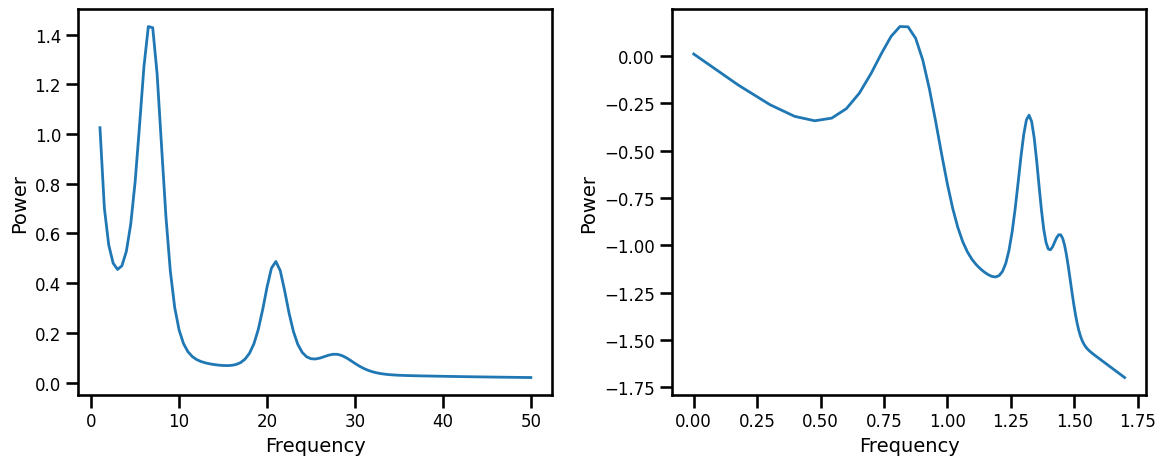

In [53]:
# Plot and check a simulated spectrum, plotted in semi-log and log space
axes = make_axes(1, 2, figsize=(12, 5))
plot_spectra(freqs, psd, grid=False, ax=axes[0])
plot_spectra(np.log10(freqs), np.log10(psd), grid=False,
             ax=axes[1], **fsaver('data_linlogpsds'))

In [54]:
# Check example fits
print('Example fits for true exponent value of {:d}:'.format(exp_val))
for name, func in fits.fit_funcs.items():
    print('  {:5s} \t {:1.3f}'.format(name, func(freqs, psd)))

Example fits for true exponent value of 1:
  OLS   	 -1.258
  OLS-EA 	 -1.208
  OLS-EO 	 -1.057
  RLM   	 -1.265
  RLM-EA 	 -1.204
  RLM-EO 	 -1.041
  RAN   	 -1.113
  RAN-EA 	 -1.086
  RAN-EO 	 -1.029
  EXP   	 -1.258
  EXP-EA 	 -1.208
  EXP-EO 	 -1.057
  SPECPARAM 	 -1.057


## Run Spectral Fits on Simulated Power Spectra

Run spectral fitting across multiple exponents and noise levels.

In [55]:
# Spectrum Settings
N_SPECTRA = 50
F_RANGE = [1, 50]

# Simulation Settings
NOISE_VALS = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
EXP_VALS = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# Set verbose setting
VERBOSE = False

In [56]:
# Run all fits
if RERUN:
    all_fits = SpectralFits()
    for exp in EXP_VALS:
        for noise in NOISE_VALS:

            if VERBOSE:
                print('Running sims for exponent val {}, noise-val {}'.format(exp, noise))

            # Simulate set of power spectra
            freqs, psds, sim_params = gen_group_power_spectra(\
                N_SPECTRA, F_RANGE, [off_val, exp], gen_peak_def(), noise, return_params=True)

            # Initialize SimFit object, and run fits
            fits = SpectralFits()
            fits.fit_spectra(exp, freqs, psds)

            # Collect results together
            all_fits = all_fits + fits

            # Save out fit data
            if SAVE_DATA:
                save_name = 'SpectralFits_exp' + str(exp) + '_N' + str(noise) + '.p'
                save_pickle(fits.errors, save_name, SIMPATH)
else:

    # Get list of simulated fit results files
    sim_files = get_files(SIMPATH)

    # Reload and combine all fit files
    all_fits = SpectralFits()

    for f_name in sim_files:
        temp = SpectralFits()
        temp.errors = load_pickle(f_name, SIMPATH)
        all_fits = all_fits + temp

## Compare Spectral Fitting

In [57]:
# Check how many PSDs are included in simulated data model fits
print(len(all_fits))

2100


In [58]:
# Check the average errors per method
print('Average error for each method:')
avg_errors = all_fits.compute_avg_errors(avg='mean')
print_results(avg_errors)

Average error for each method:
   RLM-EO   		 0.04840
   OLS-EO   		 0.05131
   EXP-EO   		 0.05131
   SPECPARAM 		 0.05232
   RLM-EA   		 0.06839
   RAN-EO   		 0.08503
   EXP-EA   		 0.09101
   OLS-EA   		 0.09101
   RAN-EA   		 0.09440
   RLM      		 0.10051
   RAN      		 0.11162
   OLS      		 0.13245
   EXP      		 0.13245


In [59]:
# Check the standard deviation of errors per method
print('Standard deviation of the errors for each method:')
std_errors = all_fits.compute_std_errors()
print_results(std_errors)

Standard deviation of the errors for each method:
   SPECPARAM 		 0.06997
   RLM-EO   		 0.07678
   EXP-EO   		 0.07884
   OLS-EO   		 0.07884
   RLM-EA   		 0.11985
   EXP-EA   		 0.13579
   OLS-EA   		 0.13579
   RLM      		 0.15693
   RAN-EO   		 0.16924
   EXP      		 0.17315
   OLS      		 0.17315
   RAN      		 0.19157
   RAN-EA   		 0.24583


In [60]:
# Check the number of fits that pass a threshold, per method
print('Percentage of fits below an error threshold:')
print_results(all_fits.compute_threshold(thresh=0.05))

Percentage of fits below an error threshold:
   RLM-EO   		 71.00000
   OLS-EO   		 69.23810
   EXP-EO   		 69.23810
   SPECPARAM 		 65.28571
   RLM-EA   		 64.42857
   RAN-EO   		 62.04762
   RAN-EA   		 59.23810
   RLM      		 54.33333
   OLS-EA   		 52.76190
   EXP-EA   		 52.76190
   RAN      		 49.38095
   OLS      		 44.19048
   EXP      		 44.19048


In [61]:
# Check the number of fits that pass a threshold, per method
print('Percentage of fits above an error threshold:')
print_results(all_fits.compute_threshold(thresh=0.5, direction='above'))

Percentage of fits above an error threshold:
   OLS      		 5.19048
   EXP      		 5.19048
   RAN      		 3.85714
   RLM      		 3.38095
   RAN-EA   		 3.04762
   OLS-EA   		 2.90476
   EXP-EA   		 2.90476
   RAN-EO   		 2.52381
   RLM-EA   		 1.95238
   OLS-EO   		 0.33333
   EXP-EO   		 0.33333
   RLM-EO   		 0.28571
   SPECPARAM 		 0.19048


## Visualizations

In [62]:
# Define labels
labels = ['OLS', 'RLM', 'RAN', 'EXP', 'SP']
mains = ['OLS', 'RLM', 'RAN', 'EXP', 'SPECPARAM']
alphas = ['OLS-EA', 'RLM-EA', 'RAN-EA', 'EXP-EA', 'SPECPARAM']
oscs = ['OLS-EO', 'RLM-EO', 'RAN-EO', 'EXP-EO', 'SPECPARAM']

In [63]:
# Split up methods by approach
main_dicts = {label : all_fits.errors[el] for label, el in zip(labels, mains)}
alphas_dicts = {label : all_fits.errors[el] for label, el in zip(labels, alphas)}
oscs_dicts = {label : all_fits.errors[el] for label, el in zip(labels, oscs)}

### Boxplots

In [64]:
# Plot settings
ylim = [0, 0.5]

#### Main Methods

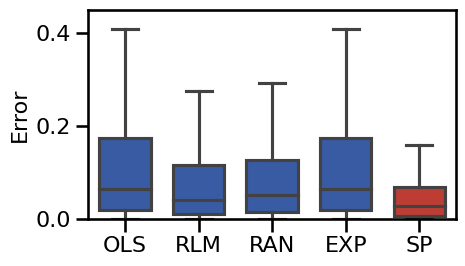

In [65]:
# Plot the boxplot errors of the main methods
plot_boxplot_errors(main_dicts, ylim=[0, 0.45], figsize=(5, 3),
                    **BOXPLOT_SETTINGS, **fsaver('results_base'))

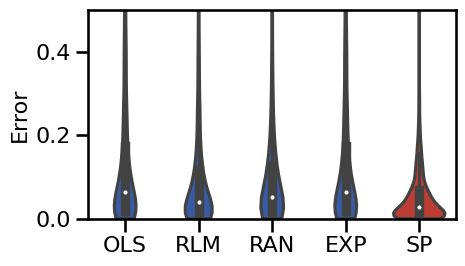

In [66]:
# Plot violin plot errors of the main methods
plot_violin_errors(main_dicts, ylim=ylim, **BOXPLOT_SETTINGS, figsize=(5, 3))

#### Alpha Exclusions

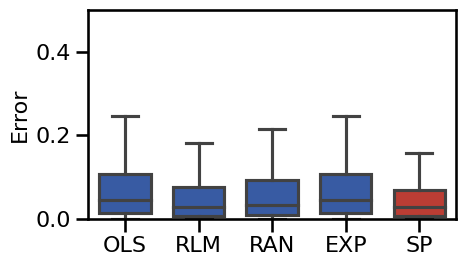

In [67]:
# Plot the boxplot errors of the alpha-exclusion methods
plot_boxplot_errors(alphas_dicts, ylim=ylim, **BOXPLOT_SETTINGS,
                    figsize=(5, 3), **fsaver('results_alph'))

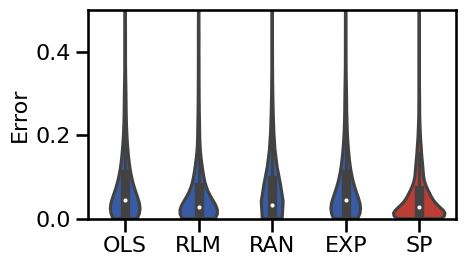

In [68]:
# Plot the violinplot errors of the alpha-exclusion methods
plot_violin_errors(alphas_dicts, **BOXPLOT_SETTINGS, ylim=ylim, figsize=(5, 3))

#### Oscillation Exclusions

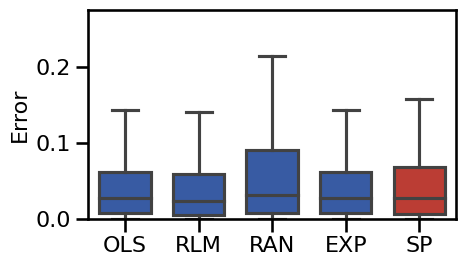

In [69]:
# Plot the boxplot errors of the oscillation-exclusion methods
plot_boxplot_errors(oscs_dicts, ylim=[0, 0.275], **BOXPLOT_SETTINGS,
                    figsize=(5, 3), **fsaver('results_osc'))

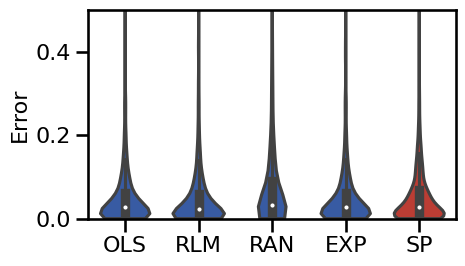

In [70]:
# Plot the violinplot errors of the oscillation-exclusion methods
plot_violin_errors(oscs_dicts, ylim=ylim, **BOXPLOT_SETTINGS, figsize=(5, 3))

#### Plot all methods together

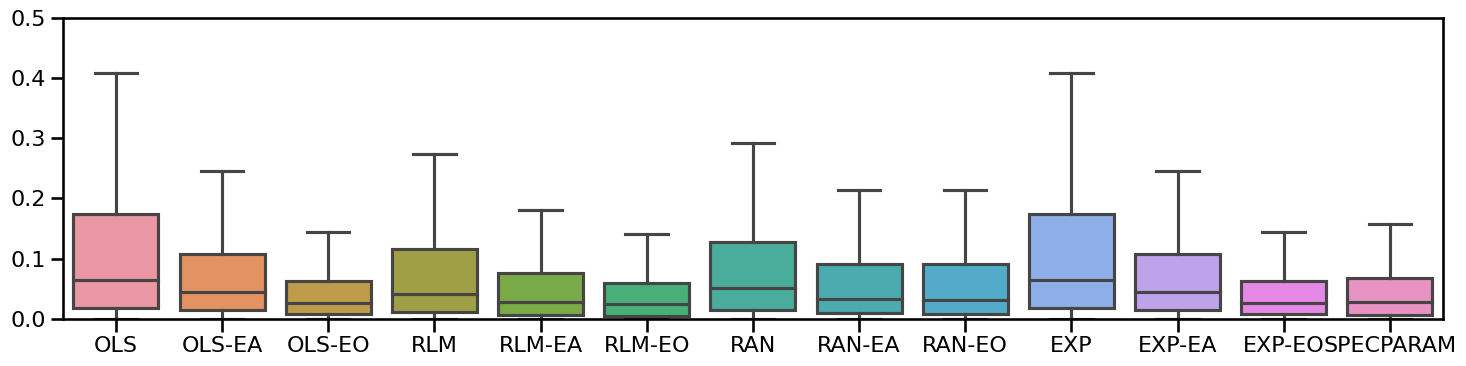

In [71]:
# Plot boxplot errors of all methods together
plot_boxplot_errors(all_fits.errors, ylim=ylim,
                    figsize=(15, 4), **fsaver('results_all'))

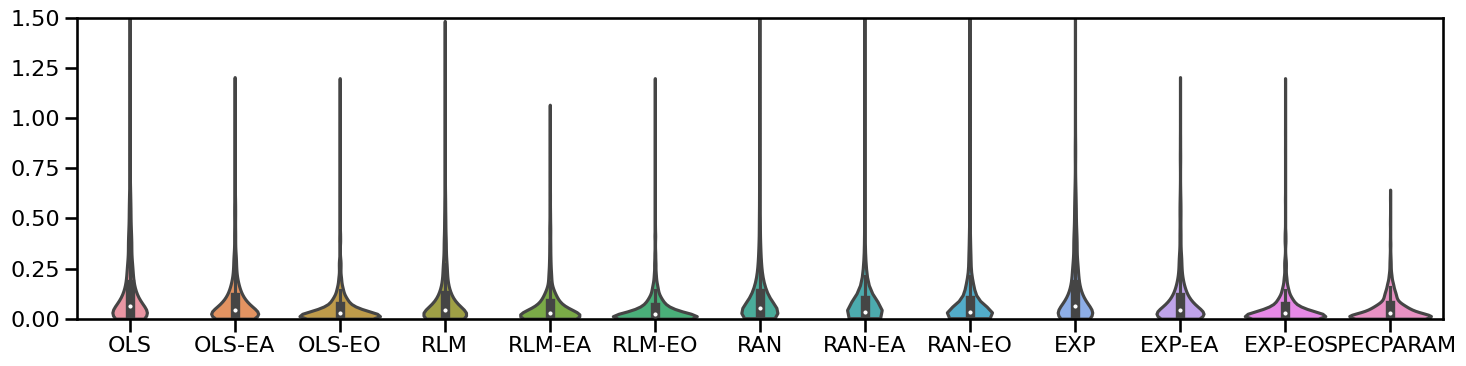

In [72]:
# Plot violinplot errors of all methods together
plot_violin_errors(all_fits.errors, ylim=[0, 1.5], figsize=[15, 4])

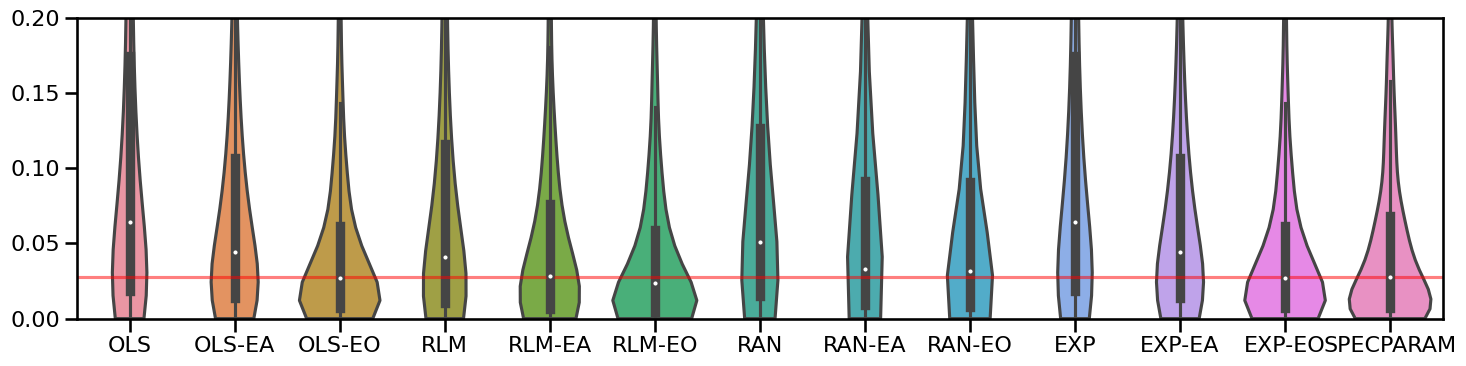

In [73]:
# Plot violin plots zoomed in
plot_violin_errors(all_fits.errors, ylim=[0, 0.2], figsize=[15, 4])
plt.gca().axhline(np.nanmedian(all_fits.errors['SPECPARAM']), color='red', alpha=0.5)

## Statistically Compare Methods

In [74]:
# Create a dataframe of the simulation errors
errors_df = pd.DataFrame(all_fits.errors)

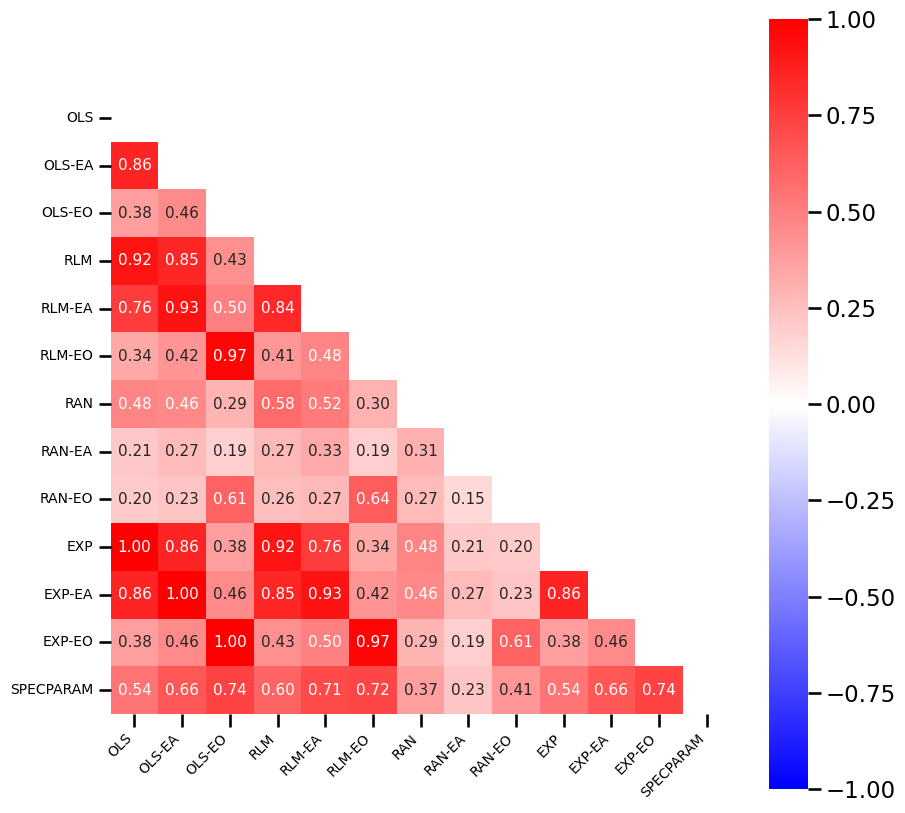

In [75]:
# Check the correlation structure between fit errors
plot_corr_matrix(errors_df.corr(), figsize=(10, 10), **fsaver('fit_corrmat'))

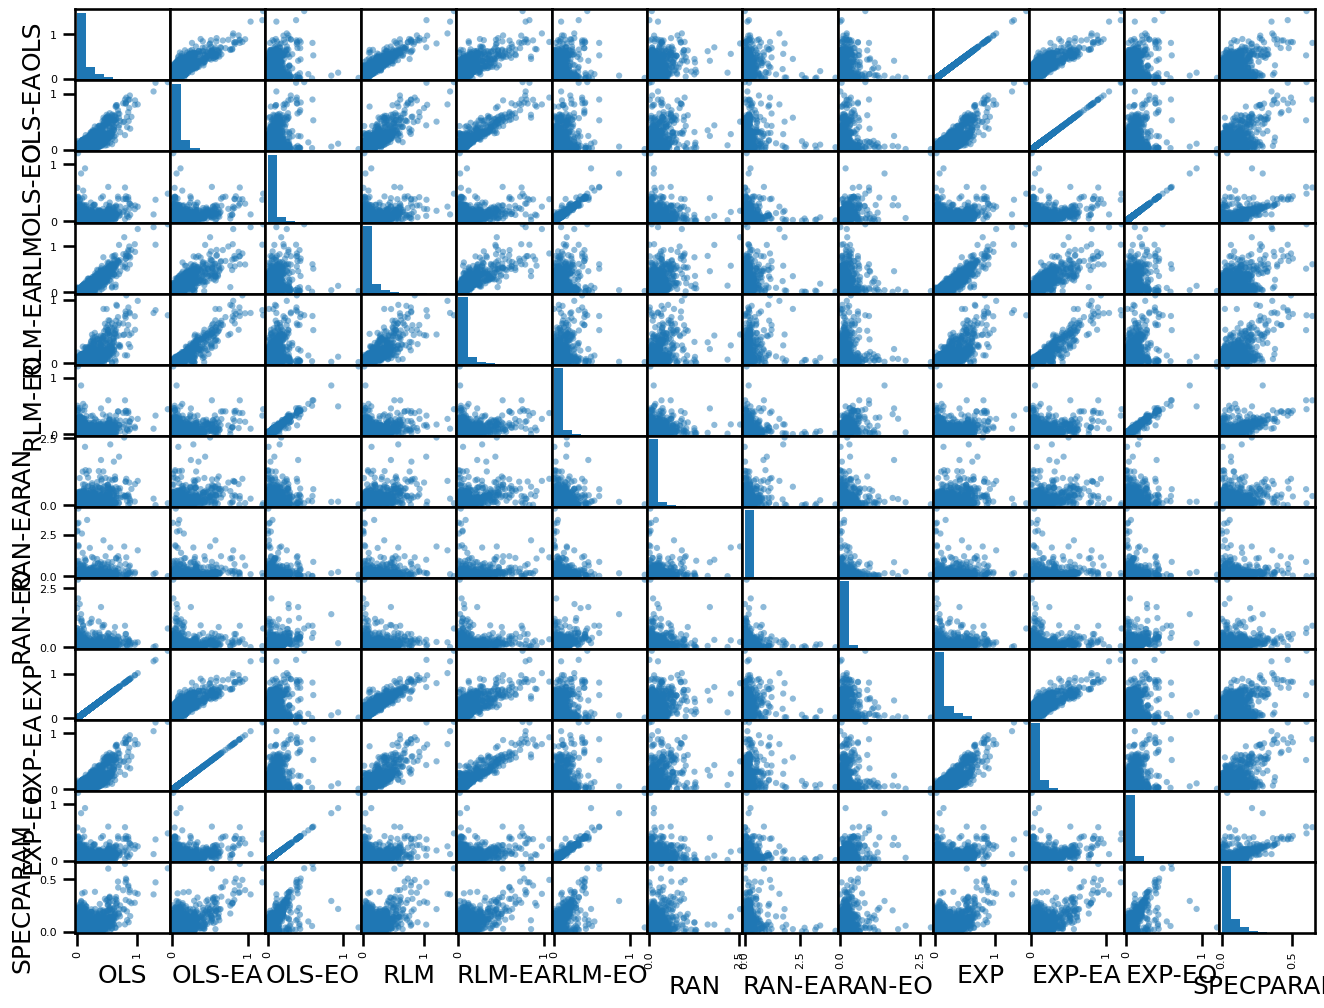

In [76]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(errors_df, figsize=[16, 12])
if SAVE_FIG: plt.savefig(FIGPATH / ('fit_corrplots.pdf'))

In [77]:
# Run comparisons between methods
comps = all_fits.compare_errors()

In [78]:
# Print out color-coded dataframe of comparison results
comps_df = pd.DataFrame(comps, index=all_fits.errors.keys(), columns=all_fits.errors.keys())
comps_df.style.applymap(color_red_or_green)

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,SPECPARAM
OLS,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.930882,0.000000,0.000000,0.000000
OLS-EA,0.000000,1.000000,0.000000,0.260450,0.000000,0.000000,0.005328,0.000000,0.000000,0.000000,0.930821,0.000000,0.000000
OLS-EO,0.000000,0.000000,1.000000,0.000000,0.238605,0.000588,0.000000,0.000000,0.000004,0.000000,0.000000,0.928981,0.566990
RLM,0.000000,0.260450,0.000000,1.000000,0.000000,0.000000,0.000283,0.000290,0.000012,0.000000,0.191574,0.000000,0.000000
RLM-EA,0.000000,0.000000,0.238605,0.000000,1.000000,0.000011,0.000000,0.000017,0.000955,0.000000,0.000000,0.253682,0.477161
RLM-EO,0.000000,0.000000,0.000588,0.000000,0.000011,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000388,0.000108
RAN,0.000002,0.005328,0.000000,0.000283,0.000000,0.000000,1.000000,0.000000,0.000000,0.000002,0.007277,0.000000,0.000000
RAN-EA,0.000000,0.000000,0.000000,0.000290,0.000017,0.000000,0.000000,1.000000,0.341517,0.000000,0.000000,0.000000,0.000000
RAN-EO,0.000000,0.000000,0.000004,0.000012,0.000955,0.000000,0.000000,0.341517,1.000000,0.000000,0.000000,0.000004,0.000028
EXP,0.930882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


## Conclusions

Overall, we can see the following patterns in these simulations:

Line fitting:
- In general, the methods perform quite similarly in terms of average error, but have different variances of the errors
- Standard robust fitting measures are not necessarily better for measuring aperiodic exponent
- Overall, the spectral parameterization approach offers low average error and few outliers